<a href="https://colab.research.google.com/github/Fordalo/Data_SCIENCE_WORK/blob/main/ARMA_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARMA MODEL (Autoregressive Moving Average Model)

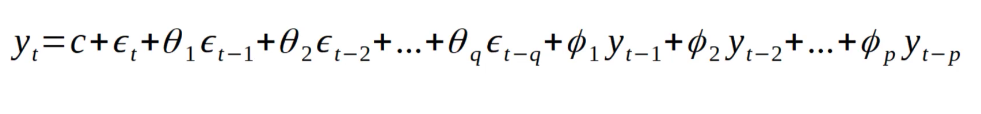



*   Combination of AR(p) and MA(q)
*   C is a constant Epsilon is noise, $Θ$ is for MA(q), $Φ$ is for AR(p)
*   together ARMA is a function of ARMA(PQ) both p and q
*   can explain relationship of time series with both random noise (moving avg) and itself (autoregression)





In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

#for progression bars
from tqdm import tqdm_notebook
from itertools import product
from google.colab import drive
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7.5)
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##simulating ARMA(1,1) here

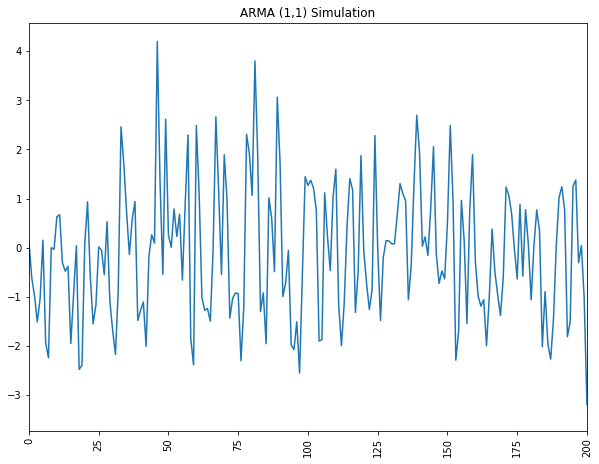

In [68]:
ar1 = np.array([1, 0.33])
ma1 = np.array([1, .9])
arma1 = ArmaProcess(ar1, ma1).generate_sample(nsample = 1000)

plt.plot(arma1)
plt.title('ARMA (1,1) Simulation')
plt.xticks(rotation = 90)
plt.xlim(0,200)
plt.show()

We cant us PACF or ACF to determine order of our ARMA model. Notice below, both plots are oscillating 

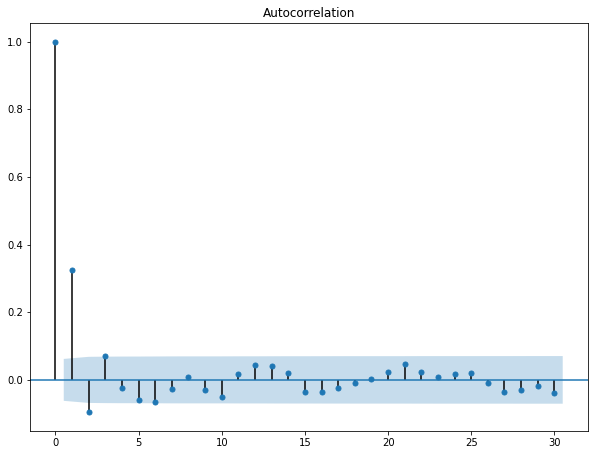

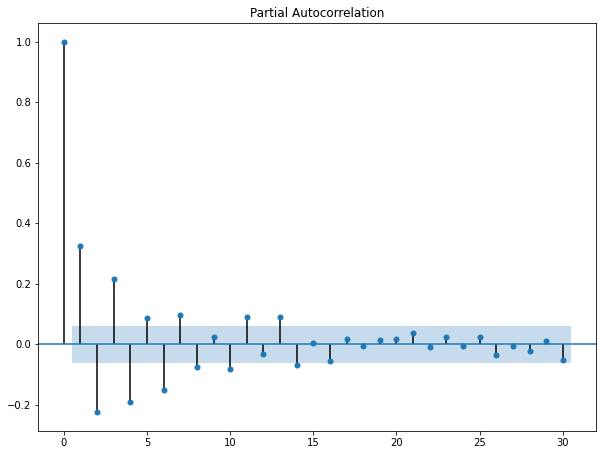

In [69]:
plot_acf(arma1);
plot_pacf(arma1);

##ARMA(2,2) process

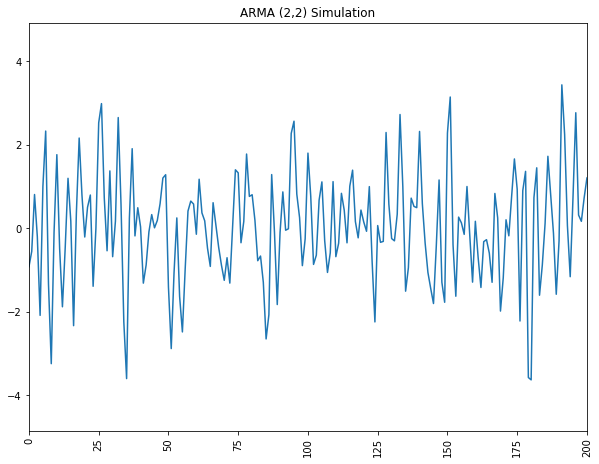

In [70]:
ar2 = np.array([1, 0.33, .5])
ma2 = np.array([1, .9, .3])
arma2 = ArmaProcess(ar2, ma2).generate_sample(nsample = 1000)
plt.plot(arma2)
plt.title('ARMA (2,2) Simulation')
plt.xticks(rotation = 90)
plt.xlim(0,200)
plt.show()

As you can see above, or ACF and pacf plots are still oscillating, and the order does not match our input

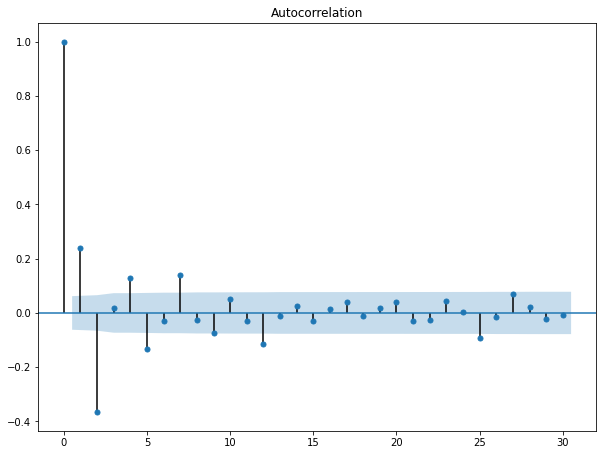

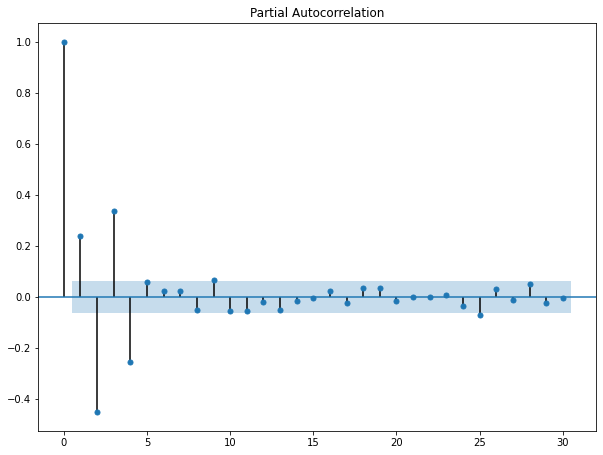

In [71]:
plot_acf(arma2);
plot_pacf(arma2);

##ARIMA: Autoregressive integrated Moving Aversage Model
Arima(p,d,q) where p and q are model orders for MA(q) and AR(p), d is the degree of differencing (number of times it was differenced)





*   if ARIMA(p,d,0) {no moving average portion}
    1.   ACF is exponentially decaying or sinusoidal
    2.   PACF has no significant peak after lag P (can be used to find order P)


*   if ARIMA(0,d,q) {no autoregression portion}
    1.   PACF is exponentially decaying or sinusoidal
    2.   ACF has no significant peak after lag P (can be used to find order of q)



In [72]:
JJdata = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data Science projects/Applied Time Series/Moving Average/jj.csv')
JJdata.head(10)

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
5,1961-04-02,0.69
6,1961-07-02,0.92
7,1961-10-01,0.55
8,1962-01-01,0.72
9,1962-04-02,0.77


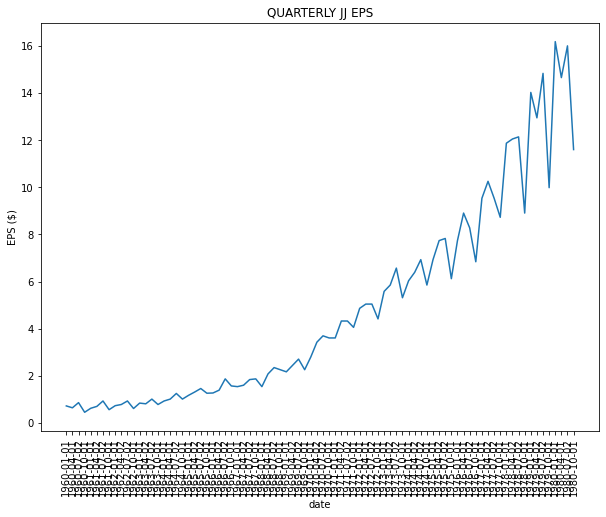

In [73]:
plt.plot(JJdata['date'], JJdata['data'])
plt.title('QUARTERLY JJ EPS')
plt.ylabel('EPS ($)')
plt.xlabel('date')
plt.xticks(rotation = 90)
plt.show()

notice the trend and seasonality, lets plot our ACF and PACF

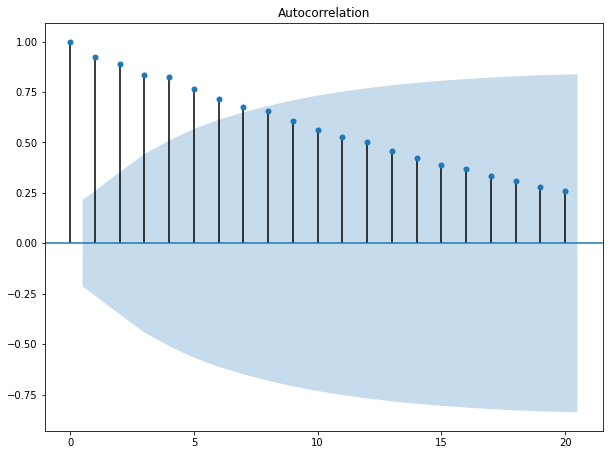

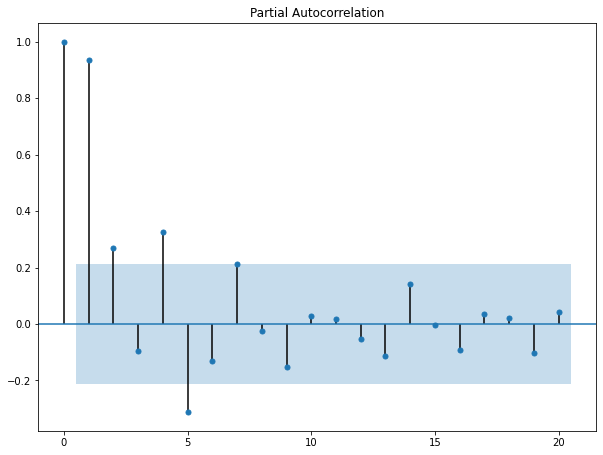

In [74]:
plot_acf(JJdata['data']);
plot_pacf(JJdata['data']);

We can clearly see that the data is not stationary. Notice the Trend in the ACF and the sinusoidal pattern in the PACF. Lets make it stationary by taking the log difference

In [75]:
JJdata['datamod'] = np.log(JJdata['data'])
JJdata['datamod'] = JJdata['datamod'].diff()
JJdata.head(10)

,date,data,datamod
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684
5,1961-04-02,0.69,0.123233
6,1961-07-02,0.92,0.287682
7,1961-10-01,0.55,-0.514455
8,1962-01-01,0.72,0.269333
9,1962-04-02,0.77,0.067139


When we take a diff, we lose the first value in our dataframe. Notice the NAN above. 

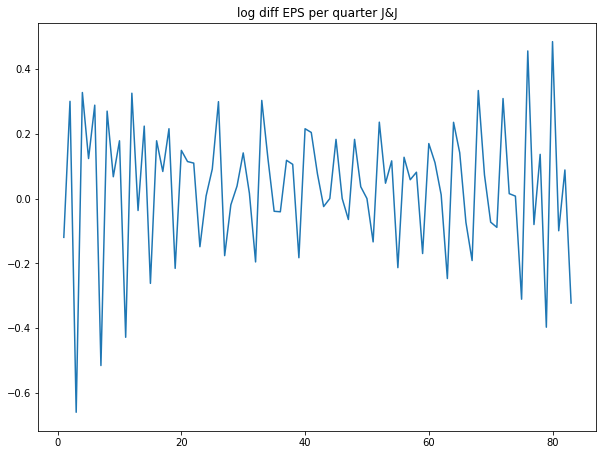

In [76]:
plt.plot(JJdata['datamod'])
plt.title('log diff EPS per quarter J&J')
plt.show()

In [77]:
#we dont want to include the NAN row
adfull_result = adfuller(JJdata['datamod'][1:])
print(f"statistic: {adfull_result[0]} PVALUE: {adfull_result[1]}")

statistic: -4.317043945811839 PVALUE: 0.000414973140444062


OUR P VALUE IS BELOW 0.05 THEREFORE OUR DATA IS STATIONARY. LETS CHECK OUT THE ACF AND PACF

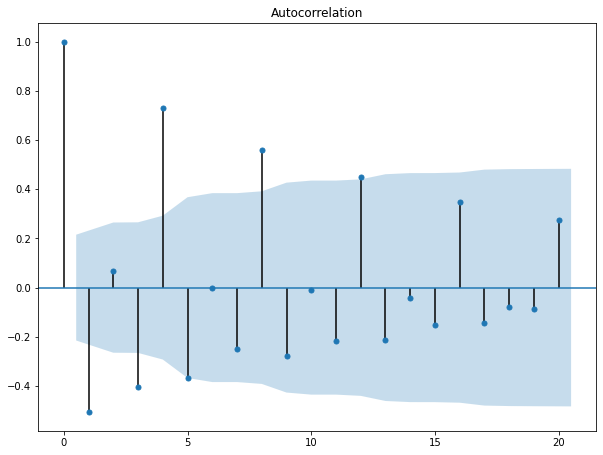

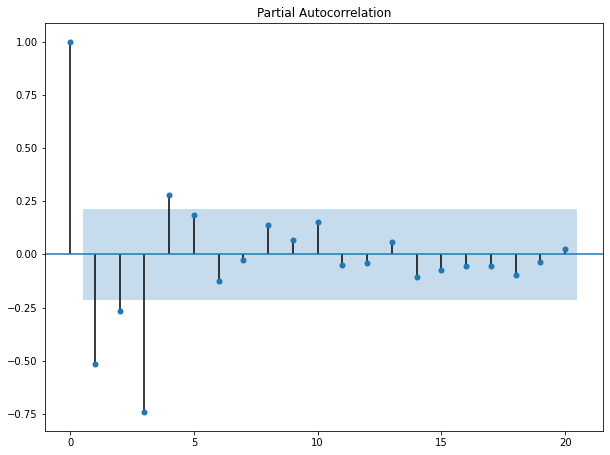

In [78]:
plot_acf(JJdata['datamod'][1:]);
plot_pacf(JJdata['datamod'][1:]);


ACF is alternating and decreasing, so is the PACF. We cant tell what the order is for the MA and AR portion of the model. We will create a function that will test a variety of orders for each portion of the model. We will test from 0 -8 for AR and MA portion, and our intergration is 1 because we differenced 1 time

In [79]:

def optomize_ARIMA(data, orderlist):
  """
    RETURNS A DATAFRAM WITH PARAMETES AND CORRESPONDING AIC
    AIC = (The Akaike information criterion is an estimator of prediction error and thereby 
    relative quality of statistical models for a given set of data. Given a collection of 
    models for the data, AIC estimates the quality of each model, relative to each 
    of the other models.)

    RETURNS ORDER_LIST: LIST WITH (P,D,Q) tuples
    endog: the observded variable
  """

  results = []

  #Allows us to display progress bars for our input list
  for order in tqdm_notebook(orderlist):
    try:
      model = SARIMAX(data, order = order, simple_differencing= False).fit(disp= False)
    except:
      continue

    aic = model.aic
    results.append([order, model.aic])

  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,d,q)', 'AIC']
  result_df = result_df.sort_values(by= 'AIC', ascending= True).reset_index(drop= True)
  return result_df


In [80]:
#For AR Portion
p_s = range(0, 8, 1)

#We only differenced our target data once
d = 1

#FOR MA PORTION
q_s = range(0, 8, 1)

#creating tuples of p,d,q
parameters = product(p_s, q_s)
parameters_list = list(parameters)

order_list_test = []

for each in parameters_list:
  each = list(each)
  each.insert(d,1)
  each = tuple(each)
  order_list_test.append(each)

order_list_test

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 1, 6),
 (1, 1, 7),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (2, 1, 6),
 (2, 1, 7),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (3, 1, 6),
 (3, 1, 7),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (4, 1, 6),
 (4, 1, 7),
 (5, 1, 0),
 (5, 1, 1),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5),
 (5, 1, 6),
 (5, 1, 7),
 (6, 1, 0),
 (6, 1, 1),
 (6, 1, 2),
 (6, 1, 3),
 (6, 1, 4),
 (6, 1, 5),
 (6, 1, 6),
 (6, 1, 7),
 (7, 1, 0),
 (7, 1, 1),
 (7, 1, 2),
 (7, 1, 3),
 (7, 1, 4),
 (7, 1, 5),
 (7, 1, 6),
 (7, 1, 7)]

In [81]:
result_df = optomize_ARIMA(JJdata['data'], order_list_test)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p,d,q)",AIC
0,"(6, 1, 3)",115.814777
1,"(4, 1, 6)",115.859214
2,"(7, 1, 1)",116.057800
3,"(5, 1, 3)",116.535593
4,"(5, 1, 2)",117.230893
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


We have now successfully found the optimal parameters for our ARIMA model. Now lets use this to run our model, and make predictions

In [82]:
best_model = SARIMAX(JJdata['data'], order = (6,1,3), simple_differencing= False)
res_final = best_model.fit(disp = False)
res_final.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   data   No. Observations:                   84
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -47.907
Date:                Fri, 12 Aug 2022   AIC                            115.815
Time:                        03:42:08   BIC                            140.003
Sample:                             0   HQIC                           125.532
                                 - 84                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4770      0.128    -11.510      0.000      -1.729      -1.225
ar.L2         -0.7751      0.146     -5.304      0.000      -1.061      -0.489
ar.L3          0.0364      0.057      0.634      0.526      -0.076       0.149
ar.L4          1.0186      0.044     23.256      0.000       0.933       1.104
ar.L5          1.4415      0.135     10.676      0.000       1.177       1.706
ar.L6          0.7418      0.146      5.082      0.000       0.456       1.028
ma.L1          0.6805      0.111      6.118      0.000       0.462       0.899
ma.L2         -0.1935      0.091     -2.121      0.034      -0.372      -0.015
ma.L3         -0.7294      0.073    -10.006      0.000      -0.872      -0.586
sigma2         0.1554      0.023      6.697      0.000       0.110       0.201
===================================================================================
Ljung-Box (Q):                       32.38   Jarque-Bera (JB):                54.09
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              38.89   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Notice AR.L3 and MA.LS are not significant because the pvalues are too high. We will now check out residuals (error

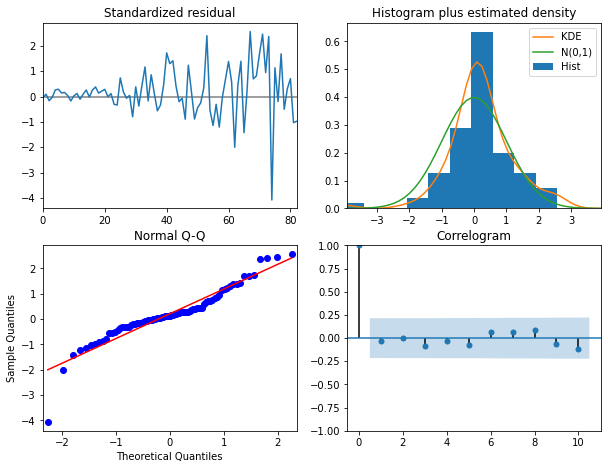

In [83]:
res_final.plot_diagnostics();

residuals are fairly gaussian so thats a pretty good model. Now lets make our forecast

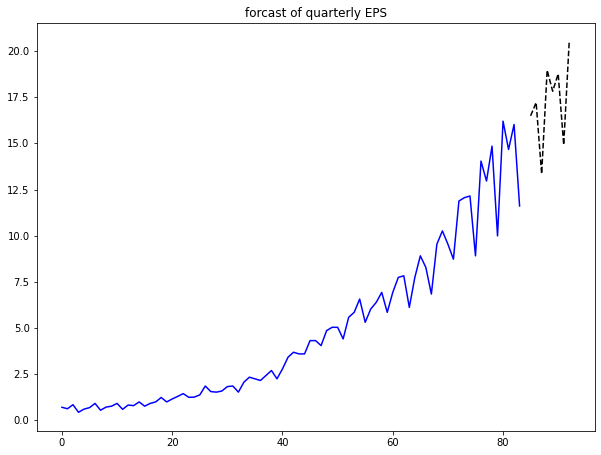

In [87]:
# our data is quarterly so here we are looking at 2 years ahead
n_forecast = 8

#nobs = number of observations
prediction = res_final.get_prediction(end = best_model.nobs + n_forecast)
idx = np.arange(len(prediction.predicted_mean))
fig, ax = plt.subplots()

#training data
ax.plot(JJdata['data'], 'blue')

#k-- means line with black dashes
ax.plot(idx[-n_forecast:], prediction.predicted_mean[-n_forecast:], 'k--')
ax.set(title = "forcast of quarterly EPS")
plt.show()


Lets evaluate the model with Mean SQ Error

In [88]:
JJdata['model'] = prediction.predicted_mean
JJdata.head()

,date,data,datamod,model
0,1960-01-01,0.71,NaN,0.000000
1,1960-04-01,0.63,-0.119545,0.709998
2,1960-07-02,0.85,0.299517,0.677594
3,1960-10-01,0.44,-0.658462,0.722116
4,1961-01-01,0.61,0.326684,0.650025


In [89]:
mse = mean_squared_error(JJdata['data'], JJdata['model'])
print(f"MSE ====> {mse}")

MSE ====> 0.16125926800459683
